Short overview of the windowpeps code. It's recommended to first check out the infinite peps code.

In [1]:
using MPSKit,PEPSKit,TensorKit,OptimKit,Plots,Test

Window peps is a mutable window of peps tensors, embedded in an infinite peps. First we instantiate an infinite peps ...

In [2]:
data = map(Iterators.product(1:2,1:2)) do (i,j)
    TensorMap(rand,ComplexF64,ℂ^2*ℂ^2*(ℂ^2)'*(ℂ^2)',(ℂ^2)')
end

peps = InfPEPS(data);

After which we can easily construct a window. The window's size needs to be a multiple of the infinite peps unit cell, because this simplified the code greatly.

In [3]:
@test_throws ArgumentError WinPEPS(peps,9,8) #this fails

window = WinPEPS(peps,8,8); #this works

The window peps environments can only be created starting from the infinite peps environments. Updating the infinite environments in-place will invalidate the window_env...

In [4]:
function bound_finalize(iter,state,ham,pars)
    maxD = 10;
    
    # check every virtual bond dimension and see if it's larger then maxD
    bigenough = reduce((a,(i,j))-> a && dim(virtualspace(state,i,j))>=maxD,
        Iterators.product(1:size(state,1),1:size(state,2)),init=true)
    
    if !bigenough 
        (state,pars) = changebonds(state,ham,OptimalExpand(trscheme=truncdim(3)),pars)
    end
    
    return (state,pars,true)
end

inf_env = environments(peps,alg=Vumps(verbose=false,finalize! = bound_finalize));

In [5]:
#initialize the environment using a 2site dmrg scheme, growing chi to 50
#afterwards, switch the algorithm to use Dmrg (faster, keeps chi constant)
window_env = environments(window,inf_env,Dmrg2(trscheme=truncdim(50),maxiter=10,verbose=false));
window_env.algorithm = Dmrg(verbose=false);

Using this we can calculate properties of the window state

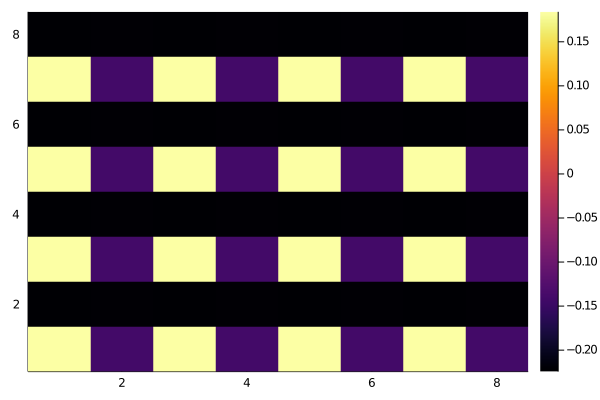

In [6]:
sz = TensorMap([1 0;0 -1],ℂ^2,ℂ^2)
heatmap(real.(expectation_value(window_env,sz)))

In [7]:
ham = nonsym_nn_xxz_ham();
expectation_value(window_env,ham)

25.67561731752458 + 4.2511845733303693e-14im

We can again find the groundstate on this patch :

In [8]:
chan = channels(window_env,ham);
optalg = LBFGS(linesearch = HagerZhangLineSearch(ϵ = 1e-3,verbosity=0),maxiter=10,verbosity=20,gradtol=1e-2)
(window,chan,delta) = find_groundstate(window,ham,optalg,chan);

┌ Info: LBFGS: initializing with f = 2112.886852869065, ‖∇f‖ = 7.3138e+00
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:35
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:104
┌ Info: trying stepsize 5.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:104
┌ Info: trying stepsize 25.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:104
┌ Info: trying stepsize 125.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:104
┌ Info: trying stepsize 625.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:104
┌ Info: trying stepsize 592.4867746702229
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:104
┌ Info: LBFGS: iter    1: f = -30.330707788022, ‖∇f‖ = 4.2154e+01, α = 5.92e+02, m = 0, nfg = 6
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/xpmbV/src/lbfgs.jl:76
┌ Info: t

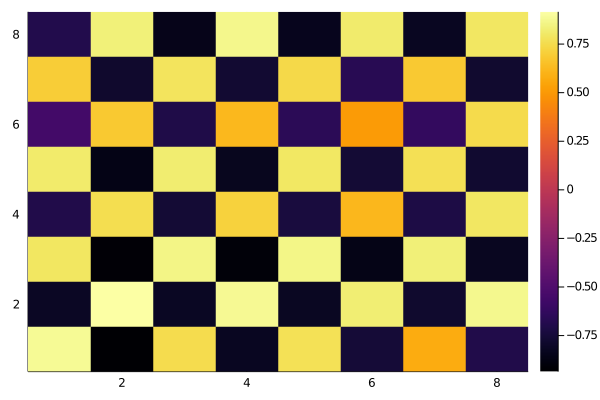

In [9]:
sz = TensorMap([1 0;0 -1],ℂ^2,ℂ^2)
heatmap(real.(expectation_value(chan,sz)))